In [1]:
from datasets import RFData, CameraData, SignalDataset, FuseDatasets
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch

In [134]:
from scipy import signal

In [146]:
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def unwrap_phase(c_signal, period=2*np.pi):
    return np.unwrap(np.angle(c_signal[...,0]+1j*c_signal[...,1]), period=period)
def angle(c_signal):
    return np.angle(c_signal[...,0]+1j*c_signal[...,1])

def highpass_filter(sig, fs=30, fc=0.1, order=2, plot=False) -> np.ndarray:
    nyqs = 0.5 * fs
    normal_fc = fc / nyqs
    b,a = signal.butter(order, normal_fc, 'high', analog=False)
    if(plot==True):
        w, h = signal.freqz(b, a, fs=30)
        fig, ax1 = plt.subplots()
        ax1.set_title('Digital filter frequency response')
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'g')
        ax2.set_ylabel('Angle (radians)', color='g')
        ax2.grid(True)
        ax2.axis('tight')
        plt.show()

    filtered = signal.filtfilt(b,a,sig, axis=0)
    return filtered

In [132]:
30/100

0.3

In [63]:
data_path = "D:\osa_new_processed"
trial_folders = os.listdir(data_path)
trial_folders = list(np.random.choice(trial_folders, 20, replace=False))
thermal_file_name = "Thermal_Camera"
num_samps_oversample = 10
data_length = 9000
fs = 30
out_len = 1800
thermal_ext = ".tiff"

In [98]:
samp_f=5e6
freq_slope=60.012e12
samples_per_chirp=256
num_tx = 3
num_rx = 4
radar_file_name = "FMCW_Radar.npy"
window_size = 25 # number of range bins to use
dataset_radar = RFData(data_path, trial_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)

In [99]:
dataset_radar[2].shape

(1800, 3, 4, 2, 25)

In [100]:
vital_dict_file_name = "gt_dict.pkl"
vital_key_radar = "CHEST"
vital_key_thermal = "AIR_flow"
l_freq_bpm = 5
u_freq_bpm = 30

In [67]:
dataset_gt_radar = SignalDataset(data_path, trial_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

In [101]:
fused_dataset_thermal = FuseDatasets([dataset_radar, dataset_gt_radar], ["radar", "gt"])

In [102]:
data_loader = torch.utils.data.DataLoader(fused_dataset_thermal, batch_size=1, shuffle=True)

In [196]:
len(dataset_gt_radar)

200

In [198]:
# apnea_idx = []
# folds = []
# count = 0
# for i, data in enumerate(data_loader):
#     # print(i)
#     try:
#         batch = data['gt'][0,:,0]

#         if(torch.mean(batch) > 0.1):
#             apnea_idx.append(i)
#     except:
#         count = count + 1
#         pass

# print(100*len(apnea_idx)/len(data_loader))
# print(count)

apnea_idx = []
folds = []
count = 0
for i, data in enumerate(dataset_gt_radar):
    # print(i)
    try:
        batch = data['gt'][0,:,0]

        if(torch.mean(batch) > 0.1):
            apnea_idx.append(i)
            patient_id = dataset_gt_radar.trial_folders[dataset_gt_radar.oversampling_idxs[i][0]]
            print(patient_id)
    except:
        count = count + 1
        pass

print(100*len(apnea_idx)/len(data_loader))
print(count)

0.0
200


In [ ]:
def get_patient_idxs(dataset, patient_ids=None):
    patient_idx_container = [ [] for _ in range(len(patient_ids)) ]

    for i in range(len(dataset.oversampling_idxs)):
        patient_id = dataset.trial_folders[dataset.oversampling_idxs[i][0]]
        for j in range(len(patient_ids)):
            if(patient_ids[j] in patient_id):
                patient_idx_container[j].append(i)
                break
    return patient_idx_container

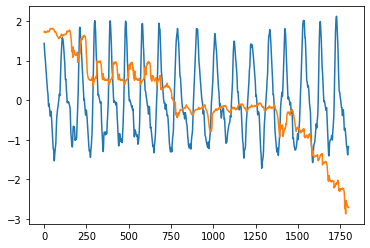

In [185]:
for data in data_loader:
    radar_data = data["radar"]
    gt_data = data["gt"]
    
    if(radar_data.shape[-1] == 25):
        plt.figure()
        plt.plot(gt_data[0,:,0])
        
        plt.plot(normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, 0].numpy())))
        plt.show()
        break

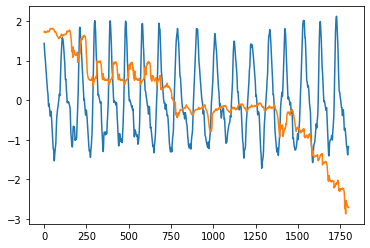

In [186]:
# 1. 25 range bins
# 2. do high pass filter
# 3. get power of the breathing signal
# 4. pick the highest power

plt.figure()
plt.plot(gt_data[0,:,0])

plt.plot(normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, 0].numpy())))
plt.show()

0.12073492982047772
0


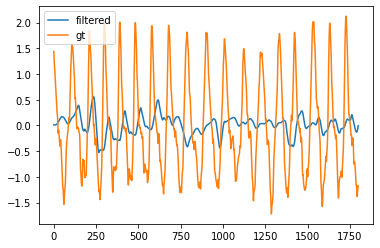

##########################################
0.13073487292792121
1


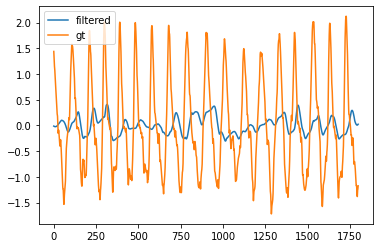

##########################################
0.31655941282895744
2


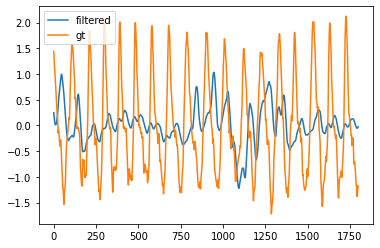

##########################################
0.15218467047241277
3


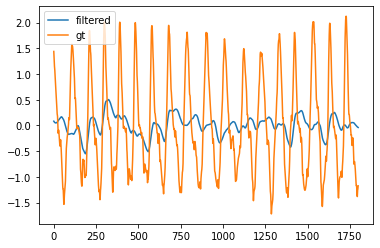

##########################################
0.15105488410710738
4


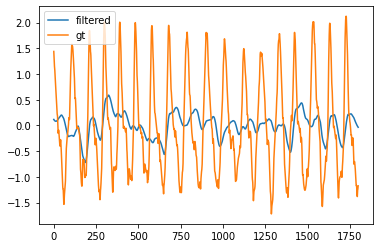

##########################################
0.09567180291428945
5


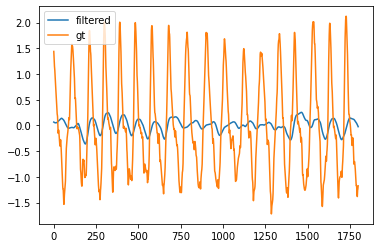

##########################################
0.09397518610653643
6


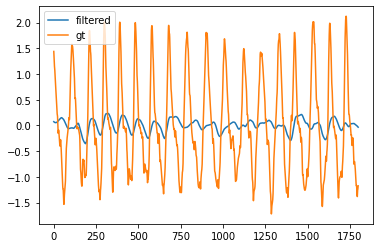

##########################################
0.09337704011036765
7


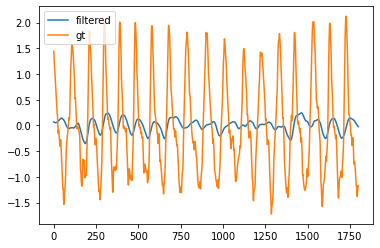

##########################################
0.09544333559030949
8


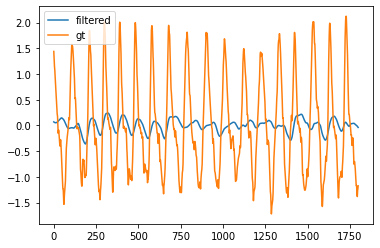

##########################################
0.10172613382538215
9


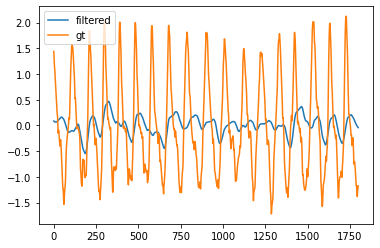

##########################################
0.09441452680638043
10


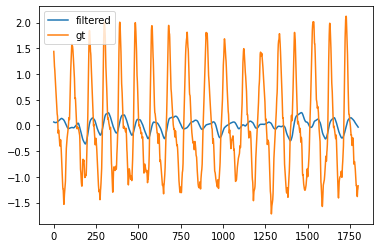

##########################################
0.1073504687289986
11


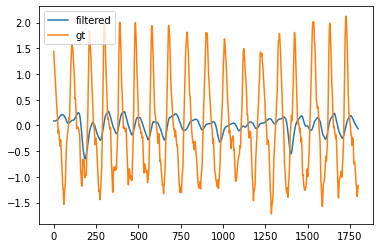

##########################################
0.45389584644690734
12


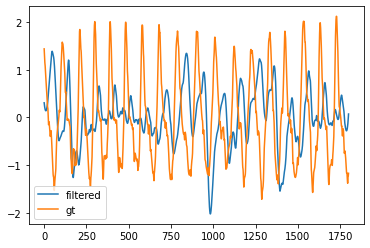

##########################################
0.5999848767083747
13


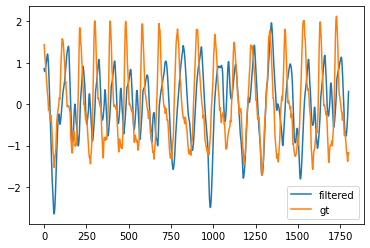

##########################################
0.1525051792389873
14


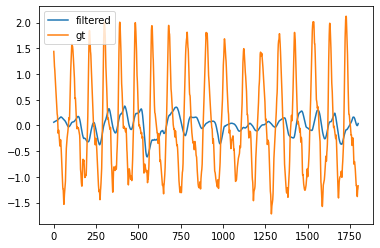

##########################################
0.6560491468407982
15


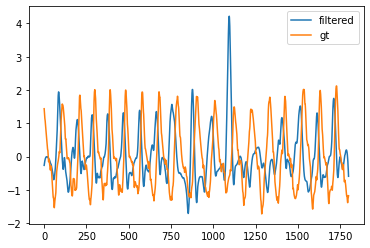

##########################################
0.5348559056478401
16


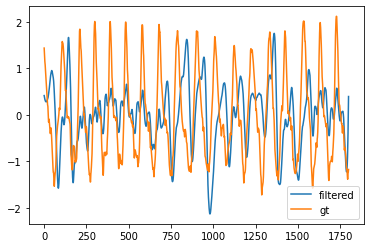

##########################################
0.38745282798383746
17


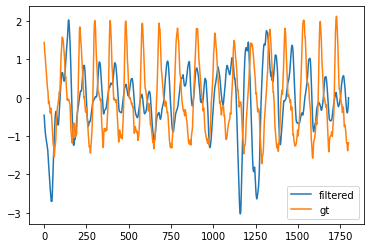

##########################################
0.5894221428723243
18


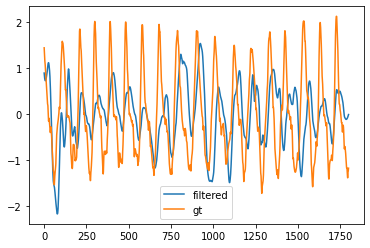

##########################################
0.7170338262172193
19


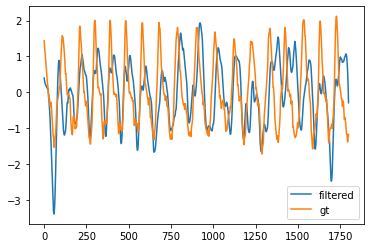

##########################################
0.5620812161779314
20


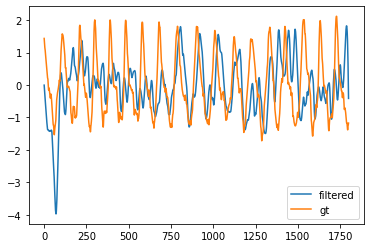

##########################################
0.14024960915608128
21


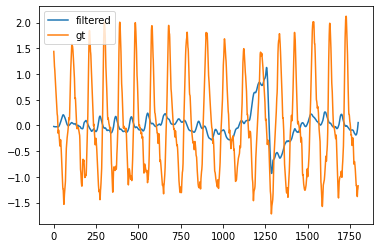

##########################################
0.7052878038026884
22


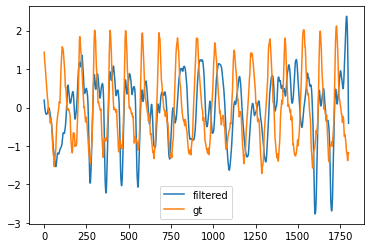

##########################################
0.8775628433810021
23


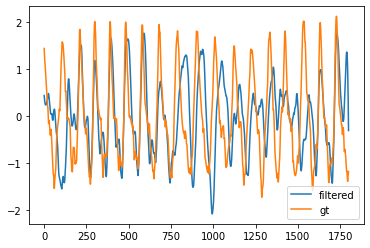

##########################################
0.5668372611523008
24


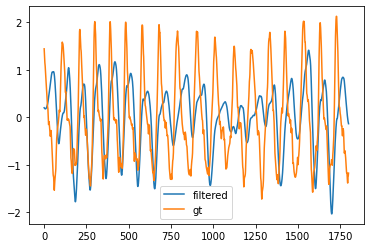

##########################################
23


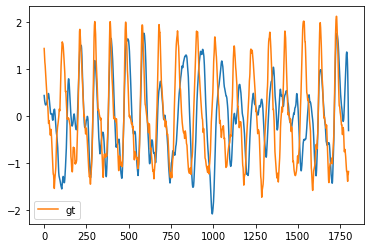

In [187]:
power = []
filt_s = []
for i in range(25):
        # plt.figure()
        # plt.plot(-normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, i].numpy(), period=2*np.pi)))
        # plt.plot(gt_data[0,:,0], label='gt')
        # # plt.figure()
        # # plt.plot(-normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, i].numpy(), period=np.pi/2)))
        # # plt.figure()
        # # plt.plot(-normalize_signal(angle(radar_data[0,:, 0, 0, :, i].numpy())))
        # plt.title(f"Range bin {i}")
        # plt.legend()
        # plt.show()

        filtered = highpass_filter(normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, i].numpy())), order=6, fc=0.1/2, plot=False)
        filtered_x = signal.savgol_filter(filtered, 41, 3)
        filt_s.append(filtered_x)

        f, Pxx_spec = signal.welch(filtered_x, fs, 'flattop', 1024, scaling='spectrum')
        # plt.figure()
        # plt.semilogy(f, np.sqrt(Pxx_spec))
        # plt.xlabel('frequency [Hz]')
        # plt.ylabel('Linear spectrum [V RMS]')
        # plt.show()
        print(np.sqrt(Pxx_spec.max()))
        power.append(np.sqrt(Pxx_spec.max()))
        print(i)
        plt.plot(filtered_x, label='filtered')
        plt.plot(gt_data[0,:,0], label='gt')
        plt.legend()
        plt.show()
        print(r"##########################################")
print(np.argmax(power))
plt.figure()
plt.plot(filt_s[np.argmax(power)])
plt.plot(gt_data[0,:,0], label='gt')
plt.legend()
plt.show()

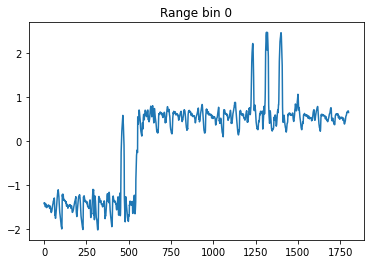

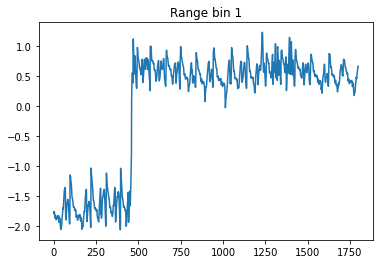

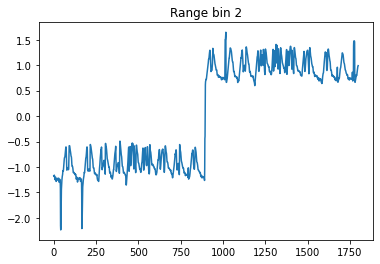

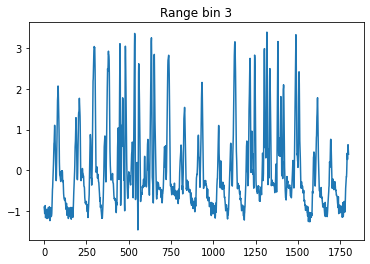

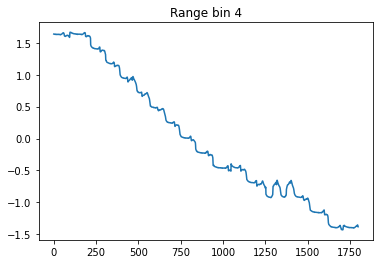

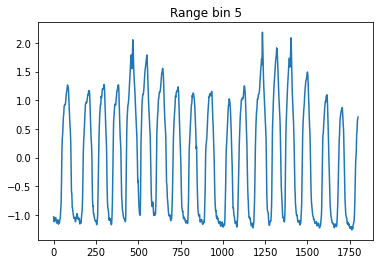

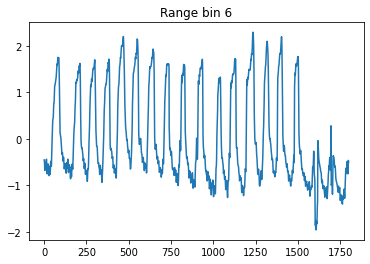

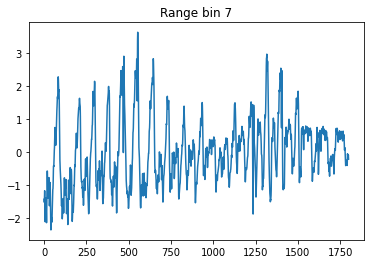

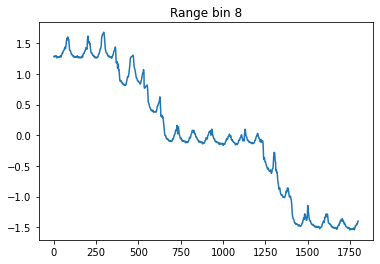

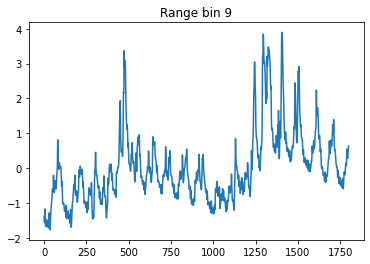

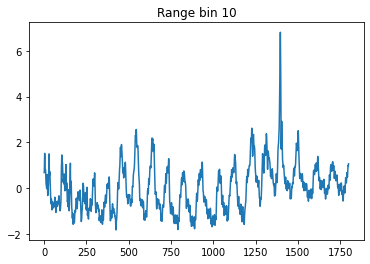

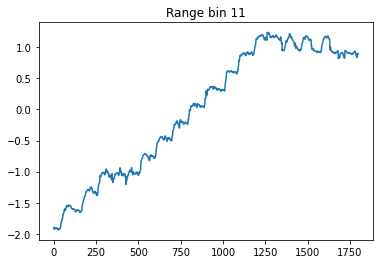

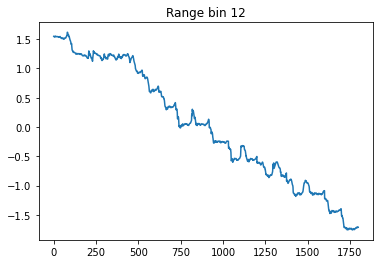

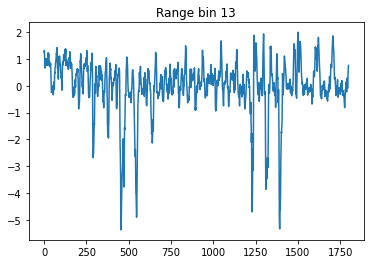

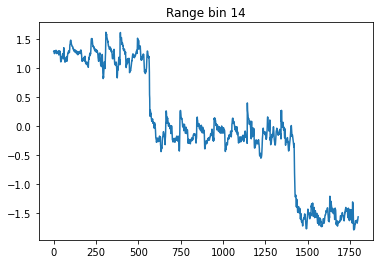

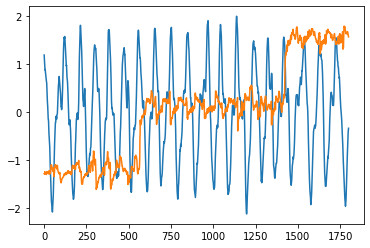

In [78]:
for i in range(15):
        plt.figure()
        plt.plot(-normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, i].numpy())))
        plt.title(f"Range bin {i}")
plt.figure()
plt.plot(gt_data[0,:,0])
plt.plot(normalize_signal(unwrap_phase(radar_data[0,:, 0, 0, :, -1].numpy())))
plt.show()